In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
def compute_curvature(p0, p1, p2):
    # p0, p1, p2 are (x, y) points
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = p2

    # Circle fitting curvature formula
    denom = (x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    if abs(denom) < 1e-6:
        return 0.0
    num = 2 * ((x1 - x2)*(y1 - y3) - (y1 - y2)*(x1 - x3))
    curvature = num / denom
    return curvature

In [3]:
def relative_distance(p1, p2):
        return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

In [4]:
def simulate_agent(current_pos, waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_decel=4.0, max_speed=100):
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.70019984
    headings = []
    vx = []
    vy = []
    speeds = []

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]

    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)
        speeds.append(sim_speed)

        # Target waypoint
        target_x, target_y = waypoints[i]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error


        # # Avoid going backwards if target is behind
        # forward_x = math.cos(sim_heading)
        # forward_y = math.sin(sim_heading)

        # dot = forward_x * dx + forward_y * dy

        # # Length of to-target vector
        # to_target_len = math.hypot(dx, dy)

        # # Cosine of angle between forward and target
        # cos_theta = dot / to_target_len

        # # If target is behind, override actions
        # if cos_theta < math.cos(math.radians(90)):
        #     desired_accel = -4
        #     desired_steering = 0
        # desired_steering *= (1 + 0.5 * (max_speed - sim_speed) / max_speed)

        # Clip to vehicle limits
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)
        # desired_accel *= max(1.0, 1.0 - abs(clipped_steering) / max_steering)
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)
        vy.append(sim_vy)
        vx.append(sim_vx)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta
        headings.append(sim_heading)

    return low_level_actions, dreamed_waypoints, headings, vx, vy, speeds

In [5]:
def compute_controlled_trajectory_old(current_pos, waypoints, num_waypoints, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=100, max_steering=100, max_decel=4.0, max_speed=100):
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.70019984
    headings = []
    vx = []
    vy = []
    speeds = []

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]

    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)
        speeds.append(sim_speed)

        # Target waypoint
        target_x, target_y = waypoints[i, :2]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Clip to vehicle limits
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)
        # desired_accel *= max(1.0, 1.0 - abs(clipped_steering) / max_steering)
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)
        vy.append(sim_vy)
        vx.append(sim_vx)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta
        headings.append(sim_heading)

    dreamed_waypoints = np.array(dreamed_waypoints)
    headings = np.array(headings)
    vx = np.array(vx)
    vy = np.array(vy)
    speeds = np.array(speeds)

    simulated_trajectory = np.column_stack((dreamed_waypoints, headings, vx, vy, speeds))

    # Columns: [x, y, heading, vx, vy, speed]
    return np.array(low_level_actions), simulated_trajectory

In [23]:
def compute_controlled_trajectory(current_pos, waypoints, num_waypoints, time_delta=0.1,
                                  max_accel=4, max_steering=1, max_speed=100):
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.70019984
    headings = []
    vx = []
    vy = []
    speeds = []

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]

    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)
        speeds.append(sim_speed)

        target_x, target_y = waypoints[i, :2]
        # Compute desired accel
        v0 = sim_speed
        v1 = waypoints[i, 6]
        v_avg = (v0 + v1) / 2
        desired_accel = (v1 - v0) / time_delta

        # Compute desired steering
        theta0 = sim_heading
        theta1 = waypoints[i, 2]
        desired_yaw_rate = (theta1 - theta0) / time_delta
        desired_steering = math.atan(desired_yaw_rate * agent_length  / v_avg)

        # Clip to vehicle limits
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)


        # # Avoid going backwards if target is behind
        forward_x = math.cos(sim_heading)
        forward_y = math.sin(sim_heading)

        dx = target_x - sim_x
        dy = target_y - sim_y

        dot = forward_x * dx + forward_y * dy

        # Length of to-target vector
        to_target_len = math.hypot(dx, dy)

        # Cosine of angle between forward and target
        cos_theta = dot / to_target_len

        # If target is behind, override actions
        if cos_theta < math.cos(math.radians(45)):
            clipped_accel = -4
            clipped_steering = 0


        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        # next_sim_speed = clip_speed(next_sim_speed)

        v_avg_real = (next_sim_speed + sim_speed) / 2

        beta =  math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (v_avg_real * math.cos(beta) * math.tan(clipped_steering)) / agent_length
        new_heading = sim_heading + yaw_rate * time_delta
        theta_avg_real = (new_heading + sim_heading) / 2

        sim_vx = v_avg_real * math.cos(theta_avg_real + beta)
        sim_vy = v_avg_real * math.sin(theta_avg_real + beta)
        vy.append(sim_vy)
        vx.append(sim_vx)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading = new_heading
        headings.append(sim_heading)

    dreamed_waypoints = np.array(dreamed_waypoints)
    headings = np.array(headings)
    vx = np.array(vx)
    vy = np.array(vy)
    speeds = np.array(speeds)

    simulated_trajectory = np.column_stack((dreamed_waypoints, headings, vx, vy, speeds))

    # Columns: [x, y, heading, vx, vy, speed]
    return np.array(low_level_actions), simulated_trajectory

In [24]:
def build_trajectories_from_params(t_values, coeffs_longi, coeffs_lat):
    x = np.polyval(coeffs_longi, t_values)
    y = np.polyval(coeffs_lat, t_values)

    # Derivatives (velocity)
    coeffs_longi_d = np.polyder(coeffs_longi)
    coeffs_lat_d = np.polyder(coeffs_lat)
    vx = np.polyval(coeffs_longi_d, t_values)
    vy = np.polyval(coeffs_lat_d, t_values)

    # Second derivatives (acceleration)
    coeffs_longi_dd = np.polyder(coeffs_longi_d)
    coeffs_lat_dd = np.polyder(coeffs_lat_d)
    ax = np.polyval(coeffs_longi_dd, t_values)
    ay = np.polyval(coeffs_lat_dd, t_values)

    # Heading (orientation)
    headings = np.arctan2(vy, vx)

    # Speed (magnitude of velocity)
    speed = np.sqrt(vx**2 + vy**2)

    # Curvature (kappa)
    curvature = (vx * ay - vy * ax) / np.power(vx**2 + vy**2, 1.5)

    # Stack all results
    local_wps = np.column_stack((x, y, headings, vx, vy, curvature, speed))

    return local_wps

In [25]:
def from_local_to_global(local_waypoints, current_x, current_y, current_heading):
    """
    Transforms local waypoints [x, y, heading, vx, vy, curvature, speed]
    into global coordinates.
    """
    cos_h = np.cos(current_heading)
    sin_h = np.sin(current_heading)
    R = np.array([[cos_h, -sin_h],
                  [sin_h,  cos_h]])

    # 1. Position: rotate + translate
    global_xy = (R @ local_waypoints[:, :2].T).T + np.array([current_x, current_y])

    # 2. Velocity: rotate only
    global_v = (R @ local_waypoints[:, 3:5].T).T

    # 3. Heading: add global offset
    global_heading = local_waypoints[:, 2] + current_heading
    # global_heading = (local_waypoints[:, 2] + current_heading + np.pi) % (2 * np.pi) - np.pi

    # 4. Curvature and speed: unchanged
    curvature = local_waypoints[:, 5]
    speed = local_waypoints[:, 6]

    # Stack everything together
    global_waypoints = np.column_stack((global_xy, global_heading, global_v, curvature, speed))
    return global_waypoints

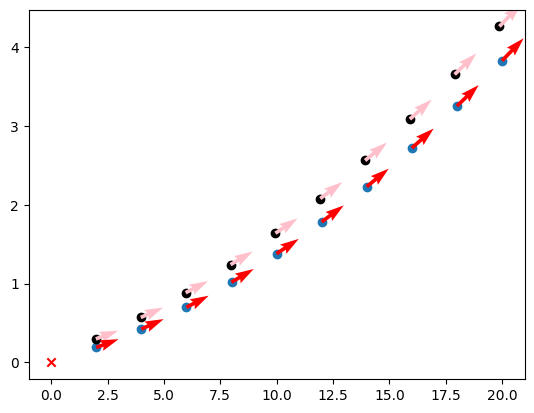

[4.96141815e-04 4.23252657e-06 3.86515166e-06 3.77078178e-06
 3.66700093e-06 3.55455601e-06 3.43456487e-06 3.30825175e-06
 3.17688120e-06 3.04171446e-06]
[-0.16786189 -0.07601442 -0.0815345  -0.09039703 -0.10047531 -0.11097169
 -0.12147517 -0.13176943 -0.14173712 -0.15131208]
[[1.11829665 0.19224498]
 [1.05321167 0.03962717]
 [1.10954751 0.03841148]
 [1.22582758 0.03805805]
 [1.37120863 0.03766344]
 [1.53016955 0.03722807]
 [1.69485623 0.03675382]
 [1.86125436 0.0362431 ]
 [2.02727623 0.03569864]
 [2.19180428 0.03512336]]


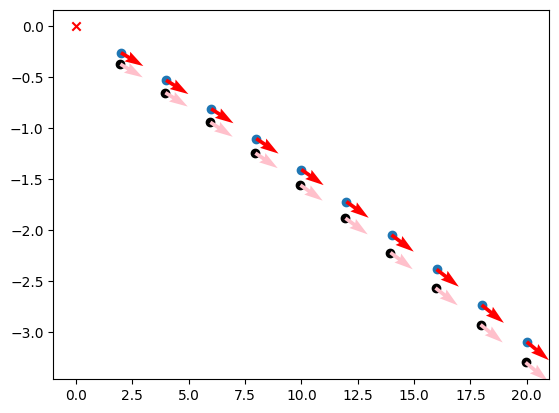

[-9.45983665e-04 -1.20787624e-07 -7.52838681e-08 -7.47324978e-08
 -7.42019468e-08 -7.36735512e-08 -7.31391823e-08 -7.25950418e-08
 -7.20394829e-08 -7.14719294e-08]
[-0.25720305 -0.05814607 -0.03992755 -0.03180994 -0.02818291 -0.02679641
 -0.02652614 -0.02681031 -0.02736812 -0.02805923]
[[ 1.73181062 -0.23701062]
 [ 1.01939756 -0.01210857]
 [ 0.66961254 -0.01033754]
 [ 0.5011263  -0.01030797]
 [ 0.42327367 -0.01027993]
 [ 0.39072149 -0.01025217]
 [ 0.38080265 -0.01022412]
 [ 0.38218304 -0.0101955 ]
 [ 0.3891951  -0.01016618]
 [ 0.39900452 -0.01013609]]


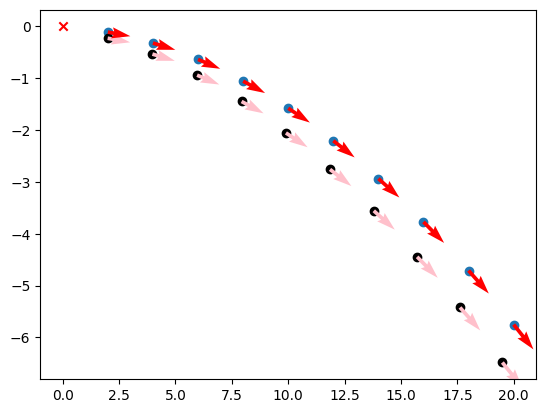

[-2.15864091e-04 -5.78940502e-05 -5.44719664e-05 -5.07097024e-05
 -7.86628157e-05 -1.98203969e-04 -3.57282916e-04 -5.46397434e-04
 -7.56624243e-04 -9.79820574e-04]
[-0.09665138 -0.13144587 -0.19537522 -0.25893928 -0.33203773 -0.44497502
 -0.59374127 -0.77355402 -0.9797388  -1.20777669]
[[ 0.63852107 -0.14635141]
 [ 1.41261503 -0.09459005]
 [ 2.32459474 -0.09252013]
 [ 3.29311521 -0.09010594]
 [ 4.         -0.08714132]
 [ 4.         -0.08380409]
 [ 4.         -0.08035936]
 [ 4.         -0.07679446]
 [ 4.         -0.07316768]
 [ 4.         -0.06953089]]


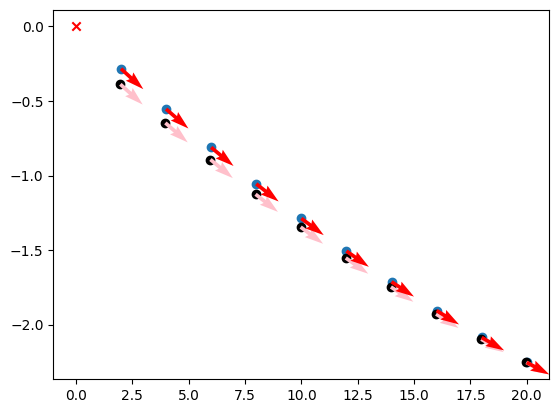

[-1.08983423e-03  6.00962011e-08  1.06541836e-07  1.07076034e-07
  1.07652719e-07  1.08236467e-07  1.08807970e-07  1.09357187e-07
  1.09878754e-07  1.10369677e-07]
[-0.2823756  -0.03301447 -0.0046673   0.00837238  0.01433886  0.01676249
  0.01741024  0.01716651  0.01647405  0.0155546 ]
[[ 1.90706016 -0.24805923]
 [ 0.78130541  0.00959541]
 [ 0.22647713  0.01161096]
 [-0.04286823  0.01163075]
 [-0.16945335  0.01165322]
 [-0.2246405   0.01167642]
 [-0.24411174  0.01169929]
 [-0.24570903  0.01172133]
 [-0.23835431  0.01174226]
 [-0.22650951  0.01176193]]


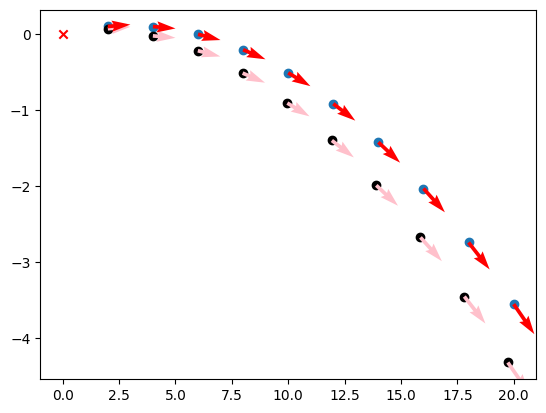

[ 6.70361851e-06 -5.55336043e-05 -5.51602283e-05 -5.35599404e-05
 -5.10125030e-05 -4.76767849e-05 -4.88194057e-05 -1.50409784e-04
 -2.90809521e-04 -4.61332411e-04]
[-0.00958124 -0.01733697 -0.06373145 -0.12182031 -0.18378855 -0.2451742
 -0.3054317  -0.40440799 -0.53861764 -0.70361315]
[[ 0.06266038  0.04626547]
 [ 0.0344551  -0.09344373]
 [ 0.53330703 -0.09319363]
 [ 1.29174838 -0.09218923]
 [ 2.17227847 -0.09054839]
 [ 3.10266337 -0.08831423]
 [ 4.         -0.08555526]
 [ 4.         -0.08236957]
 [ 4.         -0.07909875]
 [ 4.         -0.07570615]]


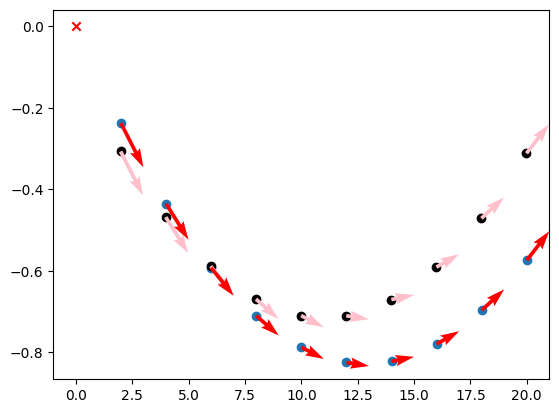

[-5.38308644e-04  3.05593235e-06  3.35923752e-06  3.39294411e-06
  3.41841763e-06  3.43432110e-06  3.43986822e-06  3.43468872e-06
  3.41869052e-06  3.39198683e-06]
[-0.17717832  0.00399785  0.02166594  0.02467673  0.02048659  0.01266883
  0.00303291 -0.00749621 -0.0184371  -0.02953097]
[[ 1.18166472 -0.19742427]
 [ 0.1966612   0.03557646]
 [-0.21649529  0.03672232]
 [-0.343354    0.03685516]
 [-0.3267828   0.03695713]
 [-0.23831052  0.03702165]
 [-0.1137976   0.03704507]
 [ 0.02872919  0.03702559]
 [ 0.18015996  0.03696252]
 [ 0.33584385  0.0368558 ]]


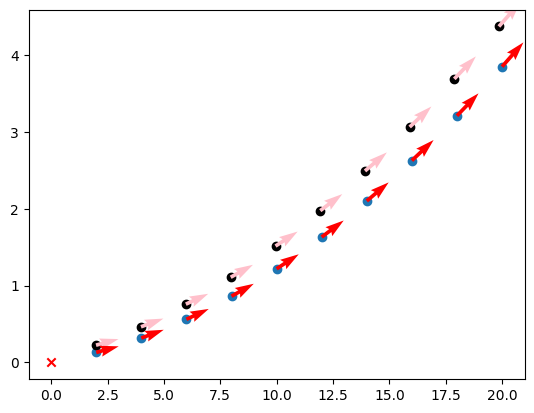

[2.12355313e-04 9.49500023e-06 9.07572724e-06 8.81193212e-06
 8.50567479e-06 8.16279996e-06 7.78992689e-06 7.39391814e-06
 6.98160398e-06 6.55955531e-06]
[-0.09560505 -0.06877238 -0.0875819  -0.1073588  -0.12712171 -0.14643625
 -0.16504758 -0.18279778 -0.19958464 -0.21534092]
[[0.63153129 0.14556408]
 [0.8417102  0.05188929]
 [1.10319922 0.05106843]
 [1.38876365 0.05051154]
 [1.68445667 0.04985115]
 [1.9829964  0.04909322]
 [2.28045719 0.0482453 ]
 [2.57461733 0.0473158 ]
 [2.86413441 0.04631365]
 [3.14813397 0.04524811]]


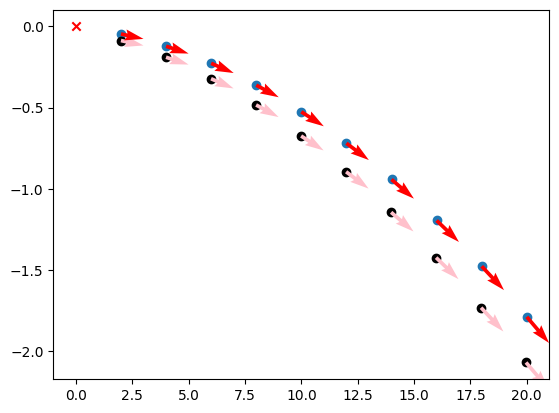

[-1.20507023e-05 -1.36965183e-06 -1.35964407e-06 -1.35034655e-06
 -1.33882870e-06 -1.32515328e-06 -1.30940135e-06 -1.29166797e-06
 -1.27205985e-06 -1.25069350e-06]
[-0.01416274 -0.01393055 -0.01953406 -0.02537833 -0.03131214 -0.03725733
 -0.04317009 -0.049024   -0.05480153 -0.06048983]
[[ 0.09267199 -0.0562376 ]
 [ 0.15786072 -0.02725548]
 [ 0.23385615 -0.02718366]
 [ 0.31515435 -0.02711448]
 [ 0.39897569 -0.02702823]
 [ 0.48390313 -0.02692511]
 [ 0.56920137 -0.02680539]
 [ 0.65447662 -0.02666943]
 [ 0.73950643 -0.02651763]
 [ 0.82415479 -0.02635047]]


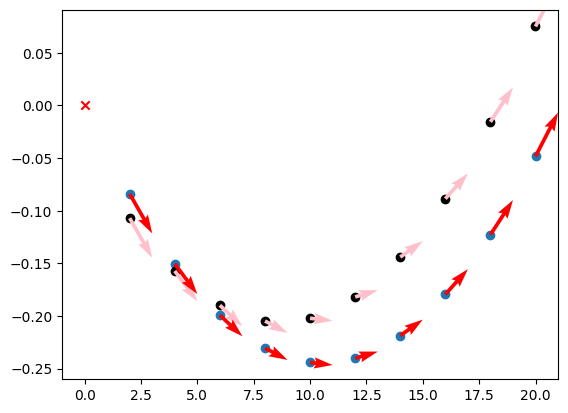

[-2.27202954e-05  2.88318498e-07  2.91089603e-07  2.91464540e-07
  2.91688246e-07  2.91745896e-07  2.91630068e-07  2.91337377e-07
  2.90866669e-07  2.90218119e-07]
[-2.16084718e-02  1.39315261e-03  3.19769723e-03  2.99443702e-03
  1.78870338e-03  8.16341928e-05 -1.87541954e-03 -3.95606226e-03
 -6.09640440e-03 -8.26382372e-03]
[[ 0.14151389 -0.06944073]
 [ 0.01230225  0.01621683]
 [-0.03682811  0.01626911]
 [-0.04590786  0.01627671]
 [-0.03495591  0.01628135]
 [-0.01398532  0.01628261]
 [ 0.01199378  0.0162803 ]
 [ 0.04047271  0.0162743 ]
 [ 0.07019356  0.01626458]
 [ 0.10052378  0.01625112]]


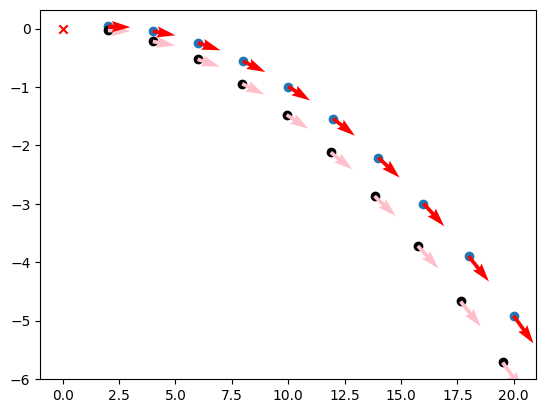

[-6.11610575e-07 -8.54699400e-05 -8.31941702e-05 -7.85898641e-05
 -7.24016333e-05 -1.95211535e-04 -3.98905403e-04 -6.50881445e-04
 -9.36138095e-04 -1.24099051e-03]
[-0.00194235 -0.06467921 -0.13777444 -0.2180197  -0.29778398 -0.41899166
 -0.58828463 -0.79897917 -1.04418824 -1.31728165]
[[ 0.01269155 -0.0208384 ]
 [ 0.48202993 -0.10776693]
 [ 1.39932728 -0.10668446]
 [ 2.5289466  -0.10447348]
 [ 3.7468494  -0.1013617 ]
 [ 4.         -0.09747415]
 [ 4.         -0.09330217]
 [ 4.         -0.08892175]
 [ 4.         -0.08440193]
 [ 4.         -0.07983171]]


In [33]:
max_speed =  20.0#50.0
num_waypoints = 10
t_values = np.linspace(0, num_waypoints/10, num_waypoints + 1)
veh_speed = 20
current_pos = 0, 0, 0, veh_speed, 0  # x, y, heading, vx, vy

for _ in range(10):
    coeffs_longi = [random.uniform(1, 1) for _ in range(3)]
    coeffs_longi[0] = 0 # c2
    coeffs_longi[1] = veh_speed # + coeffs_longi[2] * 0.1# c1
    coeffs_longi[2] = 0 # c0

    coeffs_lat = [random.uniform(-1, 1) for _ in range(3)]

    coeffs_lat[0] *= 6# * veh_speed / max_speed #c2 10
    coeffs_lat[1] *= 3#* veh_speed / max_speed # c1 3 *
    coeffs_lat[2] = 0 # c0

    # Build trajectories (x, y, heading, vx, vy, curvature, speeds)
    local_waypoints = build_trajectories_from_params(t_values, coeffs_longi, coeffs_lat)
    current_x, current_y, current_heading, _, _ = current_pos  # assuming [x, y, yaw]

    # Rotation matrix (2x2)
    global_waypoints = from_local_to_global(local_waypoints, current_x, current_y, current_heading)


    # Control actions from trajectory
#     control_actions, simulated_trajectory = compute_controlled_trajectory(current_pos, global_waypoints[1:],
#                                                                           num_waypoints=len(t_values)-1)
    control_actions, simulated_trajectory = compute_controlled_trajectory(current_pos, global_waypoints[1:],
                                                                          num_waypoints=len(t_values)-1)

    ##### Plot
    plt.scatter(global_waypoints[1:, 0], global_waypoints[1:, 1],
                label=f"longi={np.round(coeffs_longi,2)}\nlat={np.round(coeffs_lat,2)}")

    plt.scatter(simulated_trajectory[:, 0], simulated_trajectory[:, 1], c='black', marker='o')
    plt.plot([], [], ' ', label=f"controls={np.round(control_actions,2)}")
    # Angles plot
    dx_controlled = np.cos(simulated_trajectory[:, 2])
    dy_controlled = np.sin(simulated_trajectory[:, 2])
    plt.quiver(simulated_trajectory[:, 0], simulated_trajectory[:, 1],
               dx_controlled, dy_controlled, angles='xy', scale_units='xy', scale=1.0, color='pink')

    pred_headings = global_waypoints[1:, 2] # np.array(pred_headings)
    dx_pred = np.cos(pred_headings)
    dy_pred = np.sin(pred_headings)
    plt.quiver(global_waypoints[1:, 0], global_waypoints[1:, 1],
            dx_pred, dy_pred, angles='xy', scale_units='xy', scale=1.0, color='red')

    plt.scatter(current_pos[0], current_pos[1], c='red', marker='x')
    plt.show()

    print(pred_headings - simulated_trajectory[:, 2])
    print(simulated_trajectory[:, 3] - global_waypoints[1:, 3])
    print(control_actions)

In [30]:
local_waypoints[:, :2]

array([[ 0. ,  0. ],
       [ 2. ,  0.6],
       [ 4. ,  1.4],
       [ 6. ,  2.4],
       [ 8. ,  3.6],
       [10. ,  5. ],
       [12. ,  6.6],
       [14. ,  8.4],
       [16. , 10.4],
       [18. , 12.6],
       [20. , 15. ]])

In [11]:
list_vx

NameError: name 'list_vx' is not defined

In [ ]:
speeds

In [ ]:
headingsglobal_waypoints

In [ ]:
global_waypoints

In [ ]:
dreamed_waypoints

In [ ]:
num_waypoints = 10
t_values = np.linspace(0, 1, num_waypoints + 1)
t_values

In [ ]:
local_waypoints

In [ ]:
dreamed_waypoints

### SIMULATE RL ENV CONTROL AND TRAJ

In [ ]:
def simulate_agent_control(current_pos, waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_speed=100):
    """
    Simulates low-level control actions for an agent following waypoints.

    Parameters:
        env: object containing entities
        agent_idx: index of the agent in env.entities
        waypoints: list of [x, y] targets
        num_waypoints: number of waypoints to simulate
        time_delta: timestep for simulation
        kp_speed: proportional gain for speed control
        kp_steering: proportional gain for steering control
        max_accel: maximum allowed acceleration
        max_steering: maximum allowed steering angle
        max_speed: maximum allowed speed
    """
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.5

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]


    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)

        target_x = waypoints[i][0]
        target_y = waypoints[i][1]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        # dx = target_x - sim_x
        # dy = target_y - sim_y
        # desired_yaw = math.atan2(dy, dx)
        if i != num_waypoints - 1:
            target_xp = waypoints[i + 1][0]
            target_yp = waypoints[i + 1][1]
            dxp = target_xp - target_x
            dyp = target_yp - target_y
            desired_yaw = math.atan2(dyp, dxp)
        else:
            dx = target_x - sim_x
            dy = target_y - sim_y
            desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Clip to vehicle limits
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta

        if i == 0:
            next_pos = sim_x, sim_y, sim_heading, sim_vx, sim_vy

    return low_level_actions, dreamed_waypoints, next_pos

In [ ]:
# Temporal succession of control and steps
num_waypoints = 10
t_values = np.linspace(0, num_waypoints/10, num_waypoints + 1)
USE_LOOKAHEAD = False

controlled_waypoints = []
pred_trajectories = []
veh_speed = 26.1263924
current_pos = 73.2060547, -206.453125, 1.82876945, -6.6878562, 25.255909  # x, y, heading, vx, vy
chosen_actions = []
# Simulate 5 actions with same trajectory predicted
headings = []
headings.append(current_pos[2])
for i in range(10):

    coeffs_longi = [random.uniform(-1, 1) for _ in range(3)]
    coeffs_longi[0] = 0.0 # c2
    coeffs_longi[1] = veh_speed # c1
    coeffs_longi[2] = 0 # c0


    coeffs_lat = [random.uniform(-1, 1) for _ in range(3)]
    coeffs_lat[0] = 5.0 # c2 10
    coeffs_lat[1] = 2.0 # c1 3
    coeffs_lat[2] *= 0 # c0

    # max_longi_acc = 3 - 1 * abs(coeffs_lat[1])
    # coeffs_longi[1] = np.clip(coeffs_longi[1], -max_longi_acc, max_longi_acc)

    # Evaluate polynomials
    longi_traj = np.polyval(coeffs_longi, t_values)
    lateral_traj = np.polyval(coeffs_lat, t_values)

    # Stack waypoints
    # Extract vehicle position and heading
    current_x, current_y, current_heading, _, _ = current_pos  # assuming [x, y, yaw]
    local_waypoints = np.stack([longi_traj, lateral_traj], axis=-1)
    local_waypoints = local_waypoints[1:] # + np.array([current_x, current_y])
    # pred_trajectories.append(local_waypoints)

    # Rotation matrix (2x2)
    cos_h = np.cos(current_heading)
    sin_h = np.sin(current_heading)
    R = np.array([[cos_h, -sin_h],
                [sin_h,  cos_h]])

    # Apply transform: rotate then translate
    global_waypoints = (R @ local_waypoints.T).T + np.array([current_x, current_y])

    # Store trajectory in global frame
    pred_trajectories.append(global_waypoints)

    control_actions, dreamed_waypoints, current_pos = simulate_agent_control(current_pos, global_waypoints, kp_steering=1.0,
                                                                             num_waypoints=len(t_values)-1, speed_init=veh_speed)

    controlled_waypoints.append(dreamed_waypoints[0])
    chosen_actions.append(control_actions[0])
    headings.append(current_pos[2])


colors = plt.cm.tab10(np.linspace(0, 1, 5))  # 5 distinct colors from the "tab10" colormap
print(chosen_actions)
for i in range(5):
    plt.scatter(pred_trajectories[i][:, 0], pred_trajectories[i][:, 1],
                color=colors[i], marker='x', s=25)
    # plt.text(pred_trajectories[i][:, 0][9], pred_trajectories[i][:, 1][9], str(i), fontsize=10, color='red')


controlled_waypoints = np.array(controlled_waypoints)
controlled_waypoints = np.vstack(([0, 0], controlled_waypoints))

plt.scatter(controlled_waypoints[:, 0], controlled_waypoints[:, 1], c='black', marker='o', s=15.0)

# Plot headings as arrows (unit vectors from angle in radians)
headings = np.array(headings)  # assuming same length as controlled_waypoints
dx = np.cos(headings)
dy = np.sin(headings)

plt.quiver(controlled_waypoints[:, 0], controlled_waypoints[:, 1],
           dx, dy, angles='xy', scale_units='xy', scale=0.6, color='pink')
# print(control_actions)
# --- Keep (0,0) at the center ---
max_range = np.max(np.abs(local_waypoints))
plt.xlim(-5, 50)
plt.ylim(-5, 20)
plt.gca().set_aspect('equal', adjustable='box')
# plt.axis("equal")
plt.scatter(0, 0, c='red', marker='x')
plt.legend(fontsize=8, loc="best")
plt.show()